> # **Bird Species Classification using Random Forests**
Kaggle link: [Birds](https://www.kaggle.com/datasets/gpiosenka/100-bird-species)

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import cv2

from tensorflow import keras
from tensorflow import expand_dims
from keras import layers
from keras.models import Sequential
from keras.layers import RandomFlip, RandomRotation, RandomZoom
from sklearn.preprocessing import LabelEncoder

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"nikouts","key":"f8a7c6b4d418febcd18f14b71a38b016"}'}

In [ ]:
! mv kaggle\ \(1\).json kaggle.json
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d gpiosenka/100-bird-species --force
! mkdir birds
! unzip 100-bird-species.zip

In [ ]:
! rm 100-bird-species.zip

In [ ]:
df = pd.read_csv('birds.csv')

In [ ]:
df.head()

,class id,filepaths,labels,data set,scientific name
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


# Creating X,Y sets

train_path = 'train/*'

train_imgs = []
train_labels = []

i = 0
num_of_labels = 10

for dir_path in glob.glob(train_path):
  label = dir_path.split("/")[-1]
  for img_path in glob.glob(os.path.join(dir_path, "*.jpg")):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    train_imgs.append(img)
    train_labels.append(label)
  i += 1
  if i == num_of_labels:
    break

In [ ]:
X_train = np.array(train_imgs)
train_labels = np.array(train_labels)

In [ ]:
test_path = 'test/*'

test_imgs = []
test_labels = []

i = 0
num_of_labels = 10

for dir_path in glob.glob(test_path):
  label = dir_path.split("/")[-1]
  for img_path in glob.glob(os.path.join(dir_path, "*.jpg")):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    test_imgs.append(img)
    test_labels.append(label)
  i += 1
  if i == num_of_labels:
    break

In [ ]:
X_test = np.array(test_imgs)
test_labels = np.array(test_labels)

# Encoding labels to integers

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(test_labels)
y_test = le.transform(test_labels)
le.fit(train_labels)
y_train = le.transform(train_labels)

# Data normalization

In [ ]:
X_train, X_test = X_train/255.0, X_test/255.0

# Convert to One-hot

In [ ]:
from keras.utils import to_categorical

y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)

In [97]:
# image shape
img_shape = (224,224,3)

# Defining our main feature extractor structure

In [142]:
from keras.applications import VGG16

vgg16 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [143]:
x = vgg16.output
x = layers.Flatten()(x)

feature_ex = Model(inputs=vgg16.input, outputs=x)
feature_ex.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

# Extracting features from X_train

In [144]:
X_for_RF = feature_ex.predict(X_train)

50/50 [==============================] - 7s 130ms/step


# Creating and testing our RandomForest

In [145]:
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier(n_estimators = 50, random_state=42) # by trial and error

In [146]:
X_for_RF.shape

(1573, 25088)

In [147]:
RF_model.fit(X_for_RF, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [148]:
X_test_feature = feature_ex.predict(X_test)

2/2 [==============================] - 0s 152ms/step


In [149]:
prediction_RF = RF_model.predict(X_test_feature)

In [150]:
prediction_RF = le.inverse_transform(prediction_RF)

In [152]:
from sklearn import metrics
print("Accuracy: {} %".format(metrics.accuracy_score(test_labels, prediction_RF)*100))

Accuracy: 98.0 %


In [153]:
cm = metrics.confusion_matrix(test_labels, prediction_RF)

<Axes: >

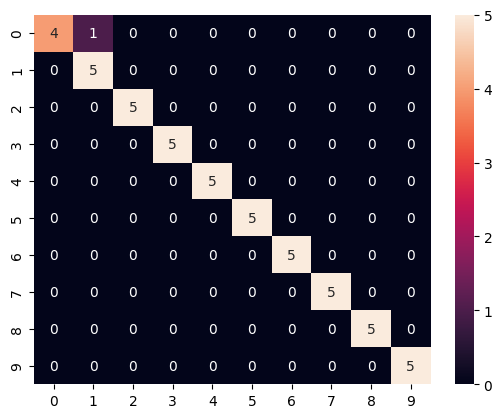

In [154]:
import seaborn as sns
sns.heatmap(cm, annot=True)

1/1 [==============================] - 0s 28ms/step


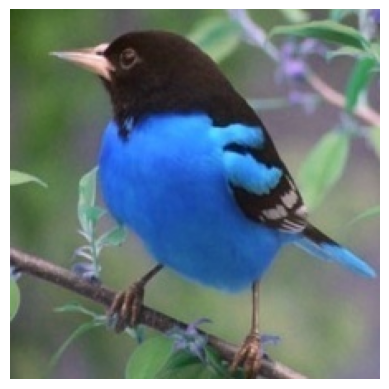

In [160]:
img = X_test[12]
plt.imshow(img)
plt.axis('off')
img_to_predict = np.expand_dims(img, axis=0)
img_to_predict_features = feature_ex.predict(img_to_predict)
prediction_RF= RF_model.predict(img_to_predict_features)[0]
prediction_RF = le.inverse_transform([prediction_RF])

In [161]:
print("The prediction for this image is: ", prediction_RF)
print("The correct label is: ", test_labels[12])

The prediction for this image is:  ['BALTIMORE ORIOLE']
The correct label is:  BALTIMORE ORIOLE
